In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
    
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import *

In [2]:
model_name = 'mobilenet'

cifar100_model_train = np.load(f'./data/CIFAR100_{model_name}_train_feat.npy')
cifar100_model_test = np.load(f'./data/CIFAR100_{model_name}_test_feat.npy')
print(cifar100_model_train.shape, cifar100_model_test.shape)

cifar100_vanilla_train = np.load(f'./data/CIFAR100_vae_vanilla_{model_name}_encoding_train.npy')
cifar100_vanilla_test = np.load(f'./data/CIFAR100_vae_vanilla_{model_name}_encoding_test.npy')
print(cifar100_vanilla_train.shape, cifar100_vanilla_test.shape)

cifar100_injected_train = np.load(f'./data/CIFAR100_vae_injected_{model_name}_encoding_train.npy')
cifar100_injected_test = np.load(f'./data/CIFAR100_vae_injected_{model_name}_encoding_test.npy')
print(cifar100_injected_train.shape, cifar100_injected_test.shape)

cifar100_adapted_train = np.load(f'./data/CIFAR100_vae_adapted_{model_name}_encoding_train.npy')
cifar100_adapted_test = np.load(f'./data/CIFAR100_vae_adapted_{model_name}_encoding_test.npy')
print(cifar100_adapted_train.shape, cifar100_adapted_test.shape)

(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()


(50000, 1280) (10000, 1280)
(50000, 1280) (10000, 1280)
(50000, 1280) (10000, 1280)
(50000, 1280) (10000, 1280)


In [3]:
input_shape = (cifar100_model_train.shape[1],)
batch_size = 128
epochs = 100
val_split=0.2
lr = 1e-4
callbacks = [
    #ReduceLROnPlateau(patience=5, factor=0.1),
    EarlyStopping(monitor='loss', patience=5)
]



In [4]:
%%time

model = Sequential( [
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(100, activation='softmax')
], name=model_name)

model.compile(
    optimizer=Adam(lr=lr),  
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#model.summary()

model_hist = model.fit(
    x=cifar100_model_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

model_eval = model.evaluate(
    x=cifar100_model_test,
    y=test_labels,
    batch_size=batch_size
)

print(f'{model.name} test - loss: {model_eval[0]}, accuracy: {model_eval[1]}')

Epoch 1/100
313/313 [==============================] - 4s 11ms/step - loss: 4.9353 - accuracy: 0.0160 - val_loss: 4.5841 - val_accuracy: 0.0187
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 4.5678 - accuracy: 0.0350 - val_loss: 4.4887 - val_accuracy: 0.0429
Epoch 3/100
313/313 [==============================] - 3s 8ms/step - loss: 4.4045 - accuracy: 0.0546 - val_loss: 4.4215 - val_accuracy: 0.0531
Epoch 4/100
313/313 [==============================] - 3s 8ms/step - loss: 4.2968 - accuracy: 0.0648 - val_loss: 4.3580 - val_accuracy: 0.0618
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 4.2131 - accuracy: 0.0750 - val_loss: 4.3109 - val_accuracy: 0.0664
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 4.1492 - accuracy: 0.0869 - val_loss: 4.2746 - val_accuracy: 0.0699
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 4.1024 - accuracy: 0.0920 - val_loss: 4.2453 - val_accuracy: 0.070

Epoch 58/100
313/313 [==============================] - 6s 18ms/step - loss: 3.3044 - accuracy: 0.2355 - val_loss: 4.3373 - val_accuracy: 0.0874
Epoch 59/100
313/313 [==============================] - 6s 18ms/step - loss: 3.3049 - accuracy: 0.2365 - val_loss: 4.3383 - val_accuracy: 0.0857
Epoch 60/100
313/313 [==============================] - 6s 18ms/step - loss: 3.2906 - accuracy: 0.2393 - val_loss: 4.3444 - val_accuracy: 0.0863
Epoch 61/100
313/313 [==============================] - 6s 18ms/step - loss: 3.2816 - accuracy: 0.2415 - val_loss: 4.3526 - val_accuracy: 0.0888
Epoch 62/100
313/313 [==============================] - 6s 19ms/step - loss: 3.2880 - accuracy: 0.2393 - val_loss: 4.3564 - val_accuracy: 0.0859
Epoch 63/100
313/313 [==============================] - 6s 18ms/step - loss: 3.2754 - accuracy: 0.2466 - val_loss: 4.3689 - val_accuracy: 0.0857
Epoch 64/100
313/313 [==============================] - 6s 18ms/step - loss: 3.2834 - accuracy: 0.2402 - val_loss: 4.3671 - val_ac

In [5]:
%%time

vanilla_model = Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='softmax')
], name='vanilla')

vanilla_model.compile(
    optimizer=Adam(lr=lr),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#vanilla_model.summary()

vanilla_hist = vanilla_model.fit(
    x=cifar100_vanilla_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

vanilla_model_eval = vanilla_model.evaluate(
    x=cifar100_vanilla_test, 
    y=test_labels,
    batch_size=batch_size
)

print(f'{vanilla_model.name} test - loss: {vanilla_model_eval[0]}, accuracy: {vanilla_model_eval[1]}')


Epoch 1/100
313/313 [==============================] - 6s 18ms/step - loss: 5.1038 - accuracy: 0.0115 - val_loss: 4.9801 - val_accuracy: 0.0113
Epoch 2/100
313/313 [==============================] - 5s 17ms/step - loss: 4.8359 - accuracy: 0.0191 - val_loss: 4.9005 - val_accuracy: 0.0152
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 4.6267 - accuracy: 0.0268 - val_loss: 4.8175 - val_accuracy: 0.0196
Epoch 4/100
313/313 [==============================] - 5s 17ms/step - loss: 4.4674 - accuracy: 0.0395 - val_loss: 4.7571 - val_accuracy: 0.0200
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 4.3306 - accuracy: 0.0514 - val_loss: 4.7177 - val_accuracy: 0.0214
Epoch 6/100
313/313 [==============================] - 5s 17ms/step - loss: 4.2214 - accuracy: 0.0656 - val_loss: 4.6927 - val_accuracy: 0.0221
Epoch 7/100
313/313 [==============================] - 5s 17ms/step - loss: 4.1299 - accuracy: 0.0798 - val_loss: 4.6768 - val_accuracy:

313/313 [==============================] - 5s 17ms/step - loss: 1.3310 - accuracy: 0.6891 - val_loss: 7.3725 - val_accuracy: 0.0220
Epoch 58/100
313/313 [==============================] - 6s 18ms/step - loss: 1.2844 - accuracy: 0.6980 - val_loss: 7.4555 - val_accuracy: 0.0223
Epoch 59/100
313/313 [==============================] - 6s 18ms/step - loss: 1.2617 - accuracy: 0.7045 - val_loss: 7.5251 - val_accuracy: 0.0231
Epoch 60/100
313/313 [==============================] - 6s 18ms/step - loss: 1.2304 - accuracy: 0.7144 - val_loss: 7.6086 - val_accuracy: 0.0228
Epoch 61/100
313/313 [==============================] - 6s 18ms/step - loss: 1.1868 - accuracy: 0.7256 - val_loss: 7.6968 - val_accuracy: 0.0229
Epoch 62/100
313/313 [==============================] - 6s 18ms/step - loss: 1.1722 - accuracy: 0.7264 - val_loss: 7.7831 - val_accuracy: 0.0227
Epoch 63/100
313/313 [==============================] - 6s 18ms/step - loss: 1.1375 - accuracy: 0.7370 - val_loss: 7.8530 - val_accuracy: 0.022

In [6]:
%%time

injected_model = tf.keras.Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(100, activation='softmax')
], name='injected')

injected_model.compile(
    optimizer=Adam(lr=lr),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#injected_model.summary()

injected_hist = injected_model.fit(
    x=cifar100_injected_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

injected_model_eval = injected_model.evaluate(
    x=cifar100_injected_test, 
    y=test_labels,
    batch_size=batch_size
)

print(f'{injected_model.name} test - loss: {injected_model_eval[0]}, accuracy: {injected_model_eval[1]}')

Epoch 1/100
313/313 [==============================] - 6s 18ms/step - loss: 5.1130 - accuracy: 0.0103 - val_loss: 4.9992 - val_accuracy: 0.0119
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 4.8498 - accuracy: 0.0187 - val_loss: 4.9298 - val_accuracy: 0.0121
Epoch 3/100
313/313 [==============================] - 5s 17ms/step - loss: 4.6637 - accuracy: 0.0243 - val_loss: 4.8620 - val_accuracy: 0.0135
Epoch 4/100
313/313 [==============================] - 5s 17ms/step - loss: 4.5089 - accuracy: 0.0361 - val_loss: 4.8091 - val_accuracy: 0.0152
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 4.3823 - accuracy: 0.0502 - val_loss: 4.7703 - val_accuracy: 0.0175
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 4.2703 - accuracy: 0.0639 - val_loss: 4.7424 - val_accuracy: 0.0175
Epoch 7/100
313/313 [==============================] - 6s 18ms/step - loss: 4.1878 - accuracy: 0.0740 - val_loss: 4.7254 - val_accuracy:

313/313 [==============================] - 5s 18ms/step - loss: 1.5084 - accuracy: 0.6411 - val_loss: 7.2486 - val_accuracy: 0.0209
Epoch 58/100
313/313 [==============================] - 6s 18ms/step - loss: 1.4825 - accuracy: 0.6449 - val_loss: 7.3226 - val_accuracy: 0.0211
Epoch 59/100
313/313 [==============================] - 6s 18ms/step - loss: 1.4501 - accuracy: 0.6562 - val_loss: 7.4002 - val_accuracy: 0.0208
Epoch 60/100
313/313 [==============================] - 6s 18ms/step - loss: 1.4129 - accuracy: 0.6699 - val_loss: 7.4695 - val_accuracy: 0.0211
Epoch 61/100
313/313 [==============================] - 6s 18ms/step - loss: 1.3820 - accuracy: 0.6742 - val_loss: 7.5506 - val_accuracy: 0.0209
Epoch 62/100
313/313 [==============================] - 6s 18ms/step - loss: 1.3574 - accuracy: 0.6777 - val_loss: 7.6248 - val_accuracy: 0.0203
Epoch 63/100
313/313 [==============================] - 6s 18ms/step - loss: 1.3320 - accuracy: 0.6827 - val_loss: 7.6968 - val_accuracy: 0.020

In [7]:
%%time

adapted_model = Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(100, activation='softmax')
],name='adapted' )

adapted_model.compile(
    optimizer=Adam(lr=lr),             
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#adapted_model.summary()

adapted_hist = adapted_model.fit(
    x=cifar100_adapted_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

adapted_model_eval = adapted_model.evaluate(
    x=cifar100_adapted_test, 
    y=test_labels,
    batch_size=batch_size
)

print(f'{adapted_model.name} test - loss: {adapted_model_eval[0]}, accuracy: {adapted_model_eval[1]}')

Epoch 1/100
313/313 [==============================] - 6s 18ms/step - loss: 5.1007 - accuracy: 0.0099 - val_loss: 4.9860 - val_accuracy: 0.0094
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 4.8374 - accuracy: 0.0136 - val_loss: 4.8972 - val_accuracy: 0.0097
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 4.7045 - accuracy: 0.0164 - val_loss: 4.8333 - val_accuracy: 0.0096
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 4.6268 - accuracy: 0.0198 - val_loss: 4.8050 - val_accuracy: 0.0099
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 4.5607 - accuracy: 0.0244 - val_loss: 4.7928 - val_accuracy: 0.0088
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 4.5060 - accuracy: 0.0300 - val_loss: 4.7934 - val_accuracy: 0.0089
Epoch 7/100
313/313 [==============================] - 6s 18ms/step - loss: 4.4579 - accuracy: 0.0352 - val_loss: 4.7938 - val_accuracy:

313/313 [==============================] - 3s 9ms/step - loss: 2.0475 - accuracy: 0.5002 - val_loss: 6.9337 - val_accuracy: 0.0101
Epoch 58/100
313/313 [==============================] - 3s 8ms/step - loss: 2.0272 - accuracy: 0.5044 - val_loss: 7.0034 - val_accuracy: 0.0106
Epoch 59/100
313/313 [==============================] - 3s 9ms/step - loss: 1.9897 - accuracy: 0.5112 - val_loss: 7.0723 - val_accuracy: 0.0109
Epoch 60/100
313/313 [==============================] - 3s 8ms/step - loss: 1.9551 - accuracy: 0.5187 - val_loss: 7.1317 - val_accuracy: 0.0100
Epoch 61/100
313/313 [==============================] - 3s 8ms/step - loss: 1.9197 - accuracy: 0.5305 - val_loss: 7.1921 - val_accuracy: 0.0106
Epoch 62/100
313/313 [==============================] - 3s 8ms/step - loss: 1.8976 - accuracy: 0.5330 - val_loss: 7.2492 - val_accuracy: 0.0103
Epoch 63/100
313/313 [==============================] - 3s 9ms/step - loss: 1.8607 - accuracy: 0.5377 - val_loss: 7.3231 - val_accuracy: 0.0108
Epoch

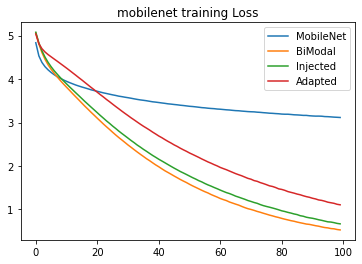

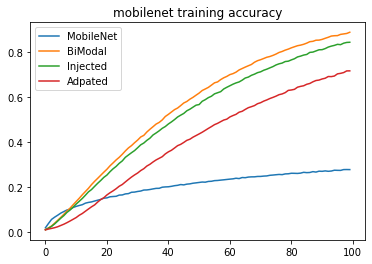

In [19]:
metric = 'accuracy'
plt.plot(model_hist.history['loss'], label=f'MobileNet')
plt.plot(vanilla_hist.history['loss'], label='BiModal')
plt.plot(injected_hist.history['loss'], label='Injected')
plt.plot(adapted_hist.history['loss'], label='Adapted')
plt.legend()
plt.title(f'{model_name } training Loss')
plt.savefig(f'./plots/{model_name}/loss.png')
plt.show()

plt.plot(model_hist.history[f'{metric}'], label=f'MobileNet')
plt.plot(vanilla_hist.history[f'{metric}'], label='BiModal')
plt.plot(injected_hist.history[f'{metric}'], label='Injected')
plt.plot(adapted_hist.history[f'{metric}'], label='Adpated')
plt.legend()
plt.title(f'{model_name} training accuracy')
plt.savefig(f'./plots/{model_name}/accuracy.png')
plt.show()

In [17]:
test_data = {
    'model': [f'{model_name}', f'{model_name}_vanilla', f'{model_name}_injected', f'{model_name}_adapted'],
    f'loss': [model_eval[0], vanilla_model_eval[0], injected_model_eval[0], adapted_model_eval[0]],
    f'acc': [model_eval[1], vanilla_model_eval[1], injected_model_eval[1], adapted_model_eval[1]]
}

test_df = pd.DataFrame(data=test_data)


                          
test_df.to_csv(f'results/{model_name}_test_df.csv') 

test_df.head()

,model,loss,acc
0,mobilenet,4.545019,0.0861
1,mobilenet_vanilla,11.004954,0.0186
2,mobilenet_injected,10.643443,0.0180
3,mobilenet_adapted,9.902885,0.0110
